# BetaVAE MLP

## Model

In [14]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from models.beta_vae import BetaVAE
from models.beta_vae_MLP import BetaVAE_MLP
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Lambda
from pytorch_lightning import Trainer

from dataset import MazeDataset
import pandas as pd 
path2csv = 'data/mazes_2gf_discrete.csv'
imgs = pd.read_csv(path2csv, header=None).values
d = MazeDataset(imgs)

model = BetaVAE_MLP(
    in_channels=1,
    latent_dim=5
)


In [116]:
imgs = pd.read_csv('data/mazes_2gf_mixed.csv', header=None).values
imgs[:, 2:11] = 1
import random
my_choices = [3,6,9]
for i in range(imgs.shape[0]):
    idx = random.choice(my_choices)
    imgs[i, idx] = 0
    imgs[i, -1] = idx

In [17]:
model.forward(d[0:16][0].reshape(-1, 169))[0].shape

torch.Size([16, 169])

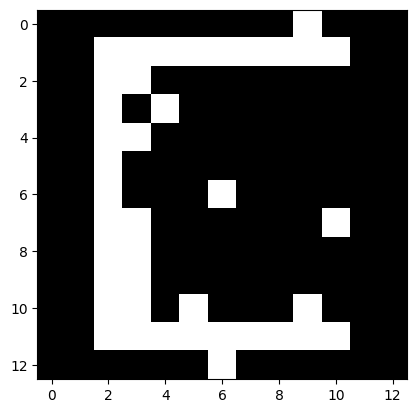

In [117]:
a = imgs[560, :-2].copy()
#a[0:13] = 1
#a[10] = 0
plt.imshow(a.reshape(13,13), cmap='binary');

In [118]:
#pd.DataFrame(imgs).to_csv('data/mazes_2gf_mixed.csv', index=False, header=False)

In [8]:
imgs.shape

(30000, 171)

## Dataset

In [2]:
class MazeDataset_old(Dataset):
    
    img_size = 14

    def __init__(self, path2csv):
        self.imgs = pd.read_csv(path2csv).values
        self.transform = Lambda(lambda x: torch.Tensor(x.reshape(*self.get_size(x))))

    def __len__(self):
        return self.imgs.shape[0]
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.zeros(img.shape[0])

    def get_size(self, batch):
        if len(batch.shape) == 1:
            return (1, self.img_size, self.img_size)
        else:
            return (batch.shape[0], 1, self.img_size, self.img_size)

class MazeDataset(Dataset):
    
    img_size = 13

    def __init__(self, data):
        self.imgs = data
        self.transform = Lambda(lambda x: torch.Tensor(x.reshape(*self.get_size(x))))

    def __len__(self):
        return self.imgs.shape[0]
    
    def __getitem__(self, idx):
        img = self.imgs[idx, :-2]
        label = self.imgs[idx, -2:]
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_size(self, batch):
        if len(batch.shape) == 1:
            return (1, self.img_size, self.img_size)
        else:
            return (batch.shape[0], 1, self.img_size, self.img_size)


In [3]:
d = MazeDataset(imgs)

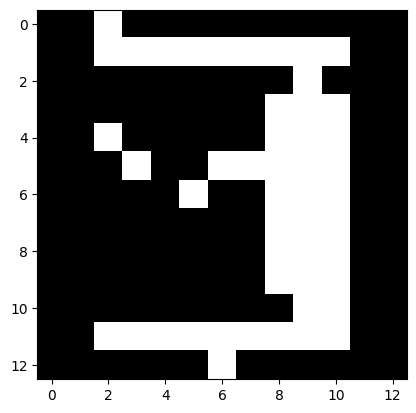

In [6]:
plt.imshow(d[17][0].squeeze(), cmap='binary');

In [6]:
d[0][0].shape

torch.Size([1, 13, 13])

In [7]:
model.forward(d[0:2][0])[0].shape

torch.Size([2, 1, 13, 13])

## Dataloaders

In [ ]:
d = MazeDataset(path2csv)
training_dataloader = DataLoader(d, batch_size=6, shuffle=True)
validation_dataloader = DataLoader(d, batch_size=16, shuffle=True)
test_dataloader = DataLoader(d[8000:], batch_size=16, shuffle=True)


In [ ]:
it = iter(validation_dataloader)

In [ ]:
a, b = next(it)

In [ ]:
a.shape

In [ ]:
b.shape

## Tensorboard


In [3]:
%load_ext tensorboard

## Trained model

In [1]:
import torch
import yaml
from models.beta_vae import BetaVAE
from models.beta_vae_MLP import BetaVAE_MLP
from models.beta_vae_MLP_CLF import BetaVAE_MLP_CLF

# load pytorch model checkpoint from file
config_file = 'configs/bbvae_MLP_CLF.yaml'
with open(config_file, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


/home/leo/.python-envs/torch-gpu-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import MazeDataset
import pandas as pd 
path2csv = 'data/mazes_2gf_discrete_big_relabelled.csv'
imgs = pd.read_csv(path2csv, header=None).values
d = MazeDataset(imgs)

In [3]:
#from torchvision.datasets import MNIST
#from torchvision import transforms
#d = MNIST(root='data', train=0, download=True, transform=transforms.ToTensor())

In [4]:
model = BetaVAE_MLP_CLF(**config['model_params'])
state = torch.load('logs/BetaVAE_MLP_CLF/version_0/checkpoints/last.ckpt')['state_dict']

# remove 'model.' prefix from state dict keys
state = {k[6:]: v for k, v in state.items()} 

model.load_state_dict(state, strict=0) 
model.eval()

BetaVAE_MLP_CLF(
  (encoder): Sequential(
    (0): Linear(in_features=169, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=16, out_features=5, bias=True)
  (fc_var): Linear(in_features=16, out_features=5, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=169, bias=True)
    (6): Sigmoid()
  )
  (clf): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=9, bias=True)
  )
)

tensor([1])


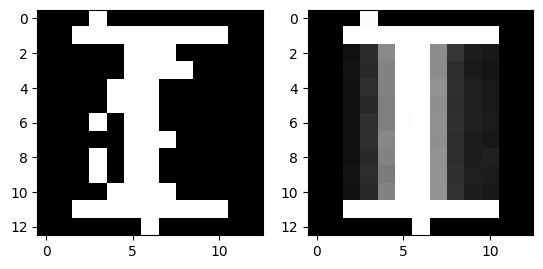

In [5]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

idx = 4500

# use this with mazes
in_, labels = d[idx:idx+1]

print( d[idx:idx+1][1])
in_rec = model.generate(in_.reshape(-1,169), labels=labels)
in_rec = in_rec.reshape(13,13).detach().numpy()

# use this with mnist
# in_ = d[idx][0]
# in_rec = model.generate(in_.reshape(1,*in_.shape)).squeeze().detach().numpy()

in_rec_thrd = np.where(in_rec > 0.5, 1, 0)
fig, axs = plt.subplots(1,2)
axs[0].imshow(in_.squeeze().detach().numpy(), cmap='binary')
axs[1].imshow(in_rec, cmap='binary')
fig.show()

In [7]:
import random

idx = random.randint(0, d.__len__()-1)
in_ = d[idx:idx+1][0]

mu, log_var = model.encode(in_)
z = model.reparameterize(mu, log_var)

In [8]:
print(idx)
print(z)

11339
tensor([[ 0.0373, -0.2655,  0.8178, -0.9975,  0.8797]], grad_fn=<AddBackward0>)


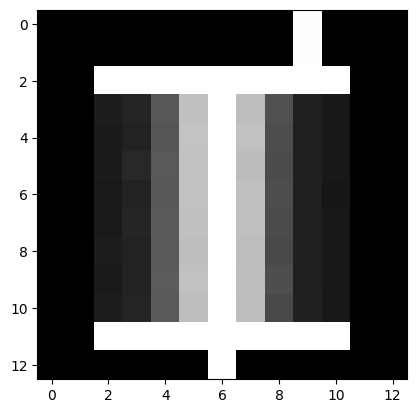

In [9]:
z_ = torch.zeros_like(z)
#z_[0, ] = 0.27
z_[0, 4] = .8
z_[0, 2] = -3
plt.imshow(model.decode(z_).squeeze().detach().numpy(), cmap='binary');

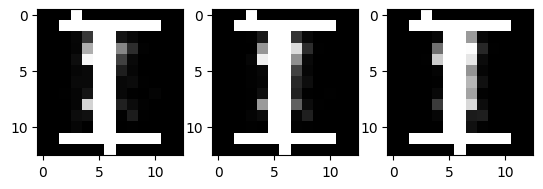

In [13]:
z_ = torch.zeros_like(z)
#z_[0, ] = 0.27
for i,val in enumerate([1,2.2,4]):
    plt.subplot(1,3,i+1)
    z_[0, 4] = val
    z_[0, 2] = -4
    plt.imshow(model.decode(z_).squeeze().detach().numpy(), cmap='binary');

In [ ]:
z_[0, 4] = val
z_[0, 2] = -4
plt.imshow(model.decode(z_).squeeze().detach().numpy(), cmap='binary');

In [11]:
z

tensor([[-0.0459,  1.2658, -2.4224, -0.3927, -1.4077]], grad_fn=<AddBackward0>)

In [9]:
# tensors of zeros with same shape as z
z_ = torch.zeros_like(z)
#rec = model.decode(z_)
#plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')

In [ ]:
import numpy as np
import time

plt.figure(figsize=(16,16))
z = z_.clone()
c = 1
n_points = 10
for i in np.linspace(-3, 3, n_points):
    for j in np.linspace(-3, 3, n_points):
        plt.subplot(n_points,n_points,c)
        z_ = z.clone()
        z_[:,1] = i
        z_[:,2] = j
        rec = model.decode(z_)
        plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')
        c += 1
plt.show()

### Remark:
- when using discrete dataset and BetaVAE_discrete_30e model, setting the latent component num. 0 to 1, makes appear a interesting thing:
    - with latent component num. 0 set to 1, the component num. 2 is able to encode all the information on the corridor, 

In [6]:
import random

idx = random.randint(0, d.__len__()-1)
in_ = d[idx:idx+1][0]

mu, log_var = model.encode(in_)
z = model.reparameterize(mu, log_var)

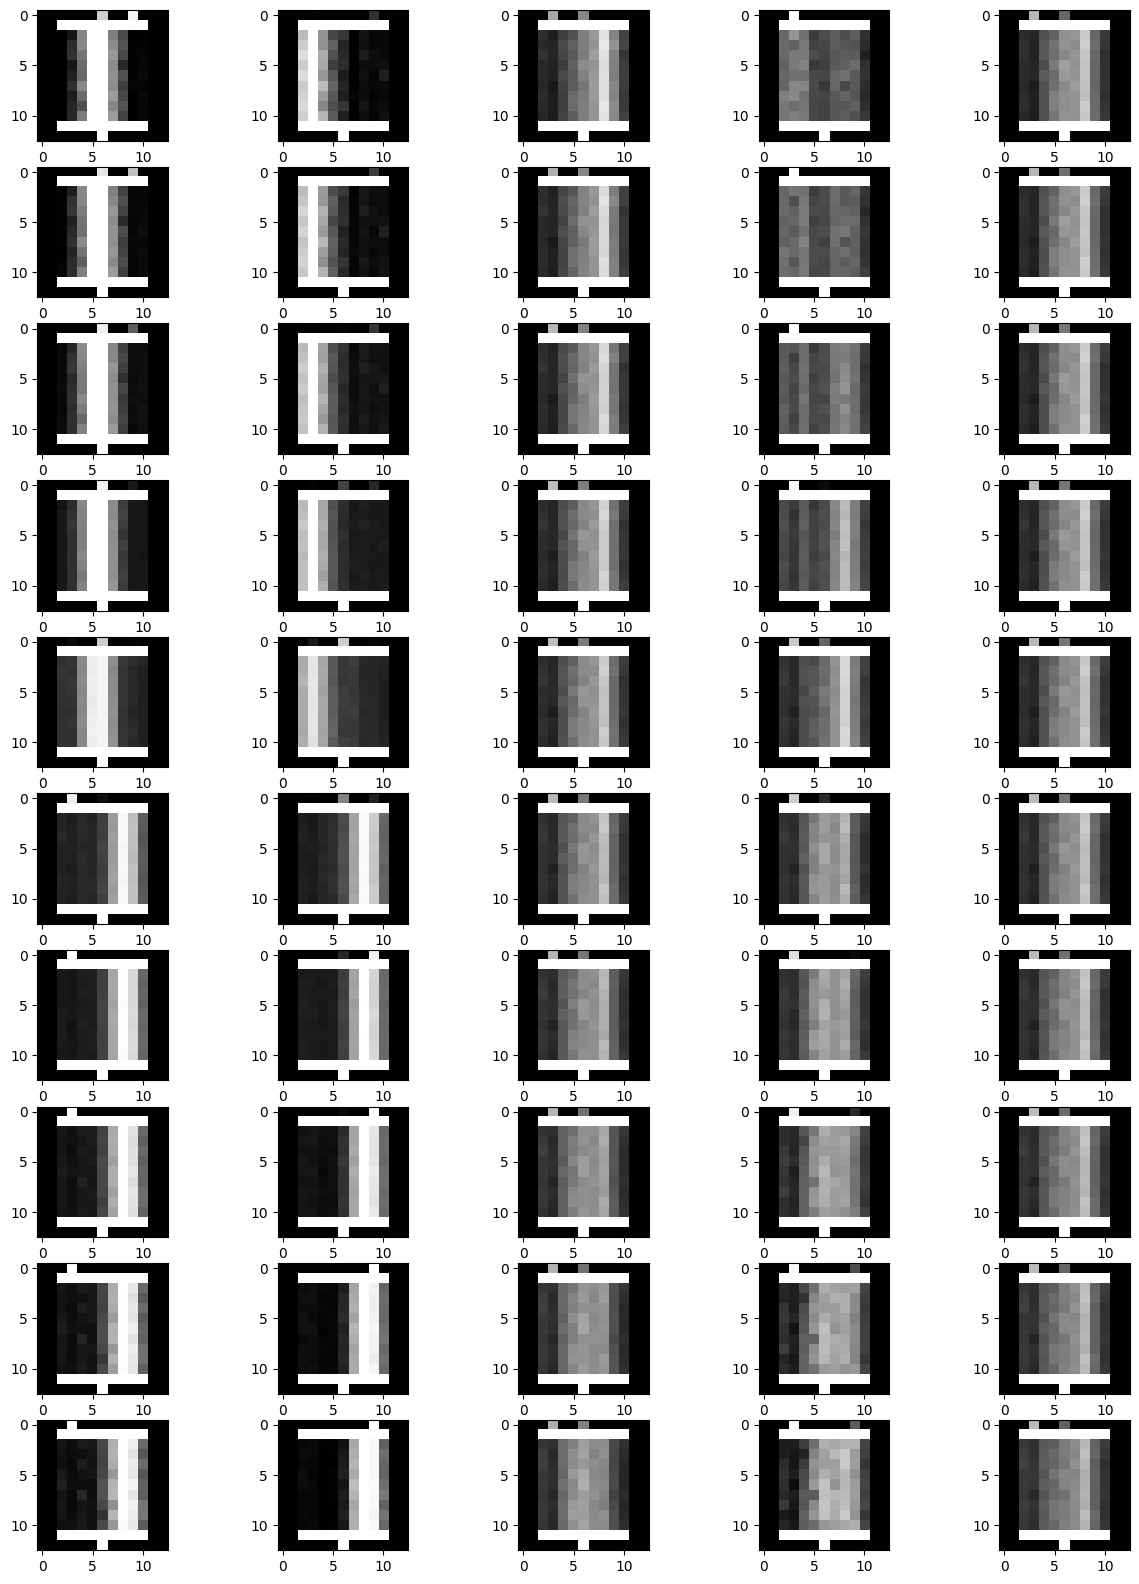

In [7]:
import numpy as np
import time

#z = z_.clone()

delta = 5
n_points = 10
#latent_channel = 4

fig, axs = plt.subplots(n_points, z.shape[1], figsize=(3*z.shape[1],2*n_points))

for latent_channel in range(z.shape[1]):
    for c, i in enumerate(np.linspace(-delta,delta,n_points)):
        z_ = torch.zeros_like(z)
        z_[:,latent_channel] = i
        #z_[:,0] = 1
        #z_[:,3] = j
        rec = model.decode(z_)
        axs[c,latent_channel].imshow(rec.squeeze().detach().numpy(), cmap='binary')
    
plt.show()

In [ ]:
import numpy as np
import time

#z = z_.clone()
delta = 4
n_points = 15
latent_channel = 2

plt.figure(figsize=(10,2*n_points))
c = 1
for i in np.linspace(-delta,delta,n_points):
    plt.subplot(n_points,1,c)
    z_ = torch.zeros_like(z)
    z_[:,latent_channel] = i
    #z_[:,3] = j
    z_[:,0] = 1 # setting this to one, the component 2 encodes all the info about the corridor
    rec = model.decode(z_)
    plt.imshow(rec.squeeze().detach().numpy(), cmap='binary')
    c += 1
plt.show()

---

## Classifier on the latent space

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

int2label = {
    '1':'l',
    '4':'c',
    '7':'r',
}

def y2label(y):
    l = pd.DataFrame(y, columns=['corridor', 'exit'], dtype=str)
    l = l.corridor.map(int2label) + l.exit.map(int2label)
    d = {label:i for i,label in enumerate(sorted(l.unique()))}
    return l.map(d), {v:k for k,v in d.items()}
    

In [9]:
X, y = d[125000:145000]

#y, int2y = y2label(y)

with torch.no_grad():
    mu, log_var = model.encode(X)
    Z = model.reparameterize(mu, log_var)

In [15]:
int2y

{0: 'cc',
 1: 'cl',
 2: 'cr',
 3: 'lc',
 4: 'll',
 5: 'lr',
 6: 'rc',
 7: 'rl',
 8: 'rr'}

/tmp/ipykernel_856402/2946263944.py:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X_[idx, 0],


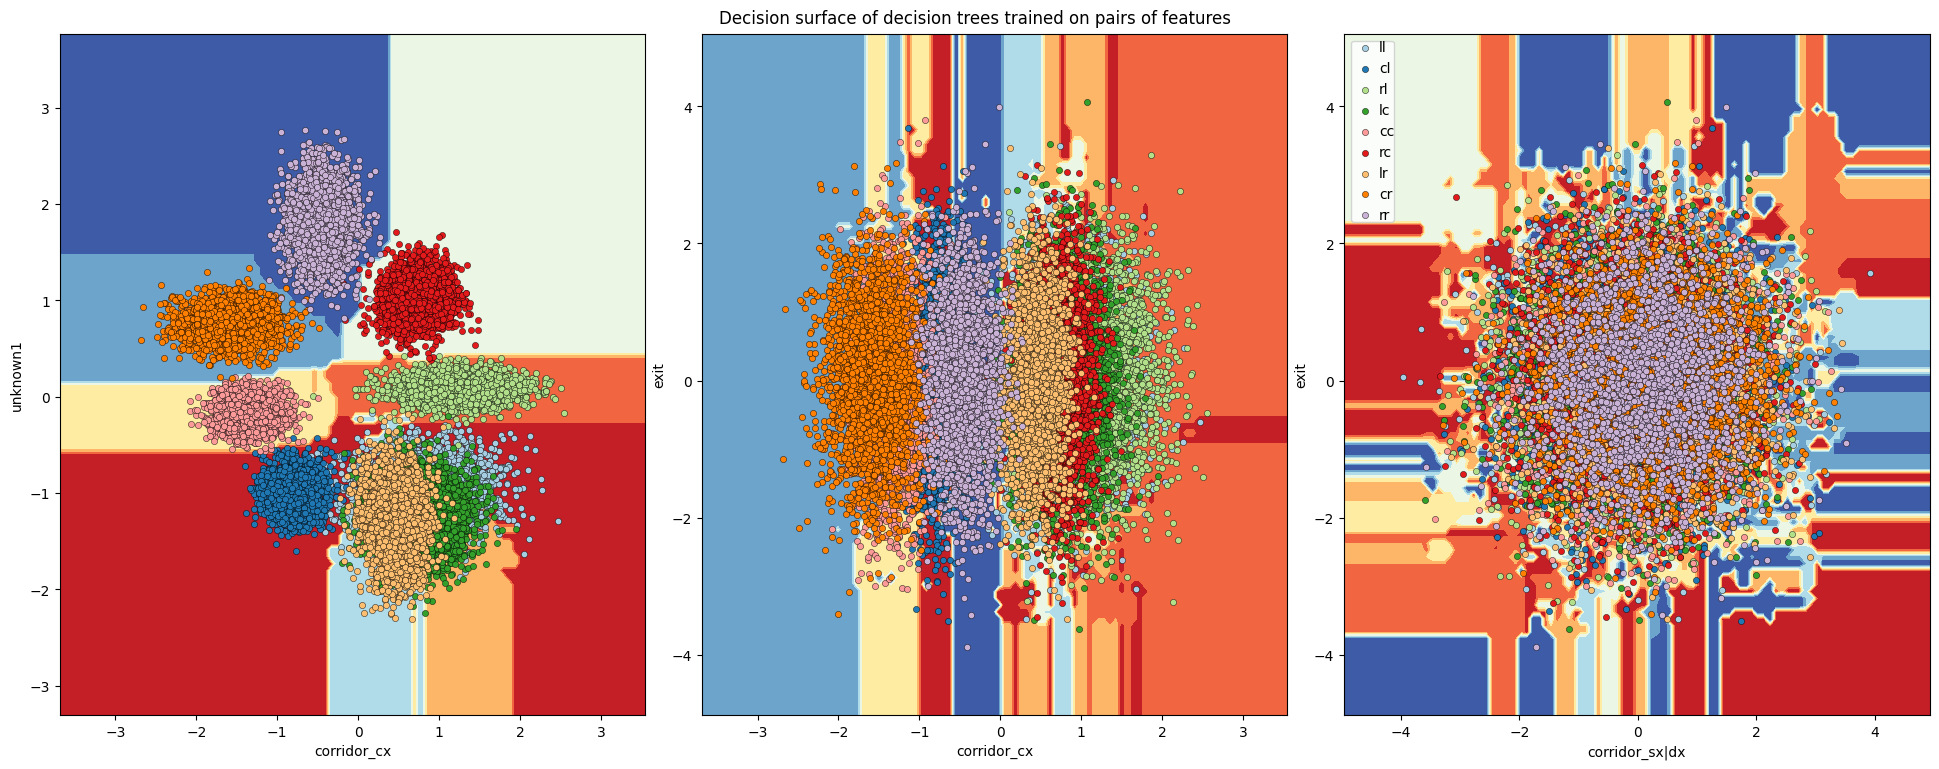

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib

idx2label = {
    0: 'll',
    1: 'cl',
    2: 'rl',
    3: 'lc',
    4: 'cc',
    5: 'rc',
    6: 'lr',
    7: 'cr',
    8: 'rr',
}

feature_names = {
    0: 'corridor_cx',
    1: 'unknown1',
    2: 'corridor_sx|dx',
    3: 'unknown2',
    4: 'exit'
}

# Parameters
n_classes = 9
plot_colors = matplotlib.cm.get_cmap('Paired')
plot_step = 0.02

plt.figure(figsize=(20, 8))

for pairidx, pair in enumerate([[0,1], [0,4], [2,4]]):
    # We only take the two corresponding features
    X_ = Z[:, pair]
    y_ = y

    # Train
    clf_ = RandomForestClassifier().fit(X_, y_)
    #clf_ = RandomForestClassifier().fit(X_, y_)

    # Plot the decision boundary
    ax = plt.subplot(1, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf_,
        X_,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=feature_names[pair[0]],
        ylabel=feature_names[pair[1]],
    )

    # Plot the training points
    for i in range(n_classes):
        idx = np.where(y_ == i)
        plt.scatter(
            X_[idx, 0],
            X_[idx, 1],
            color=plot_colors(i),
            label=idx2label[i],
            #cmap=plt.cm.RdYlBu,
            edgecolor="black",
            linewidth=.3,
            s=20,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="upper left", borderpad=0, handletextpad=0)
_ = plt.axis("tight")
plt.show()

In [48]:
Z[:,0] = 1

In [12]:
clf = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9)
clf.fit(Z, y)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9)

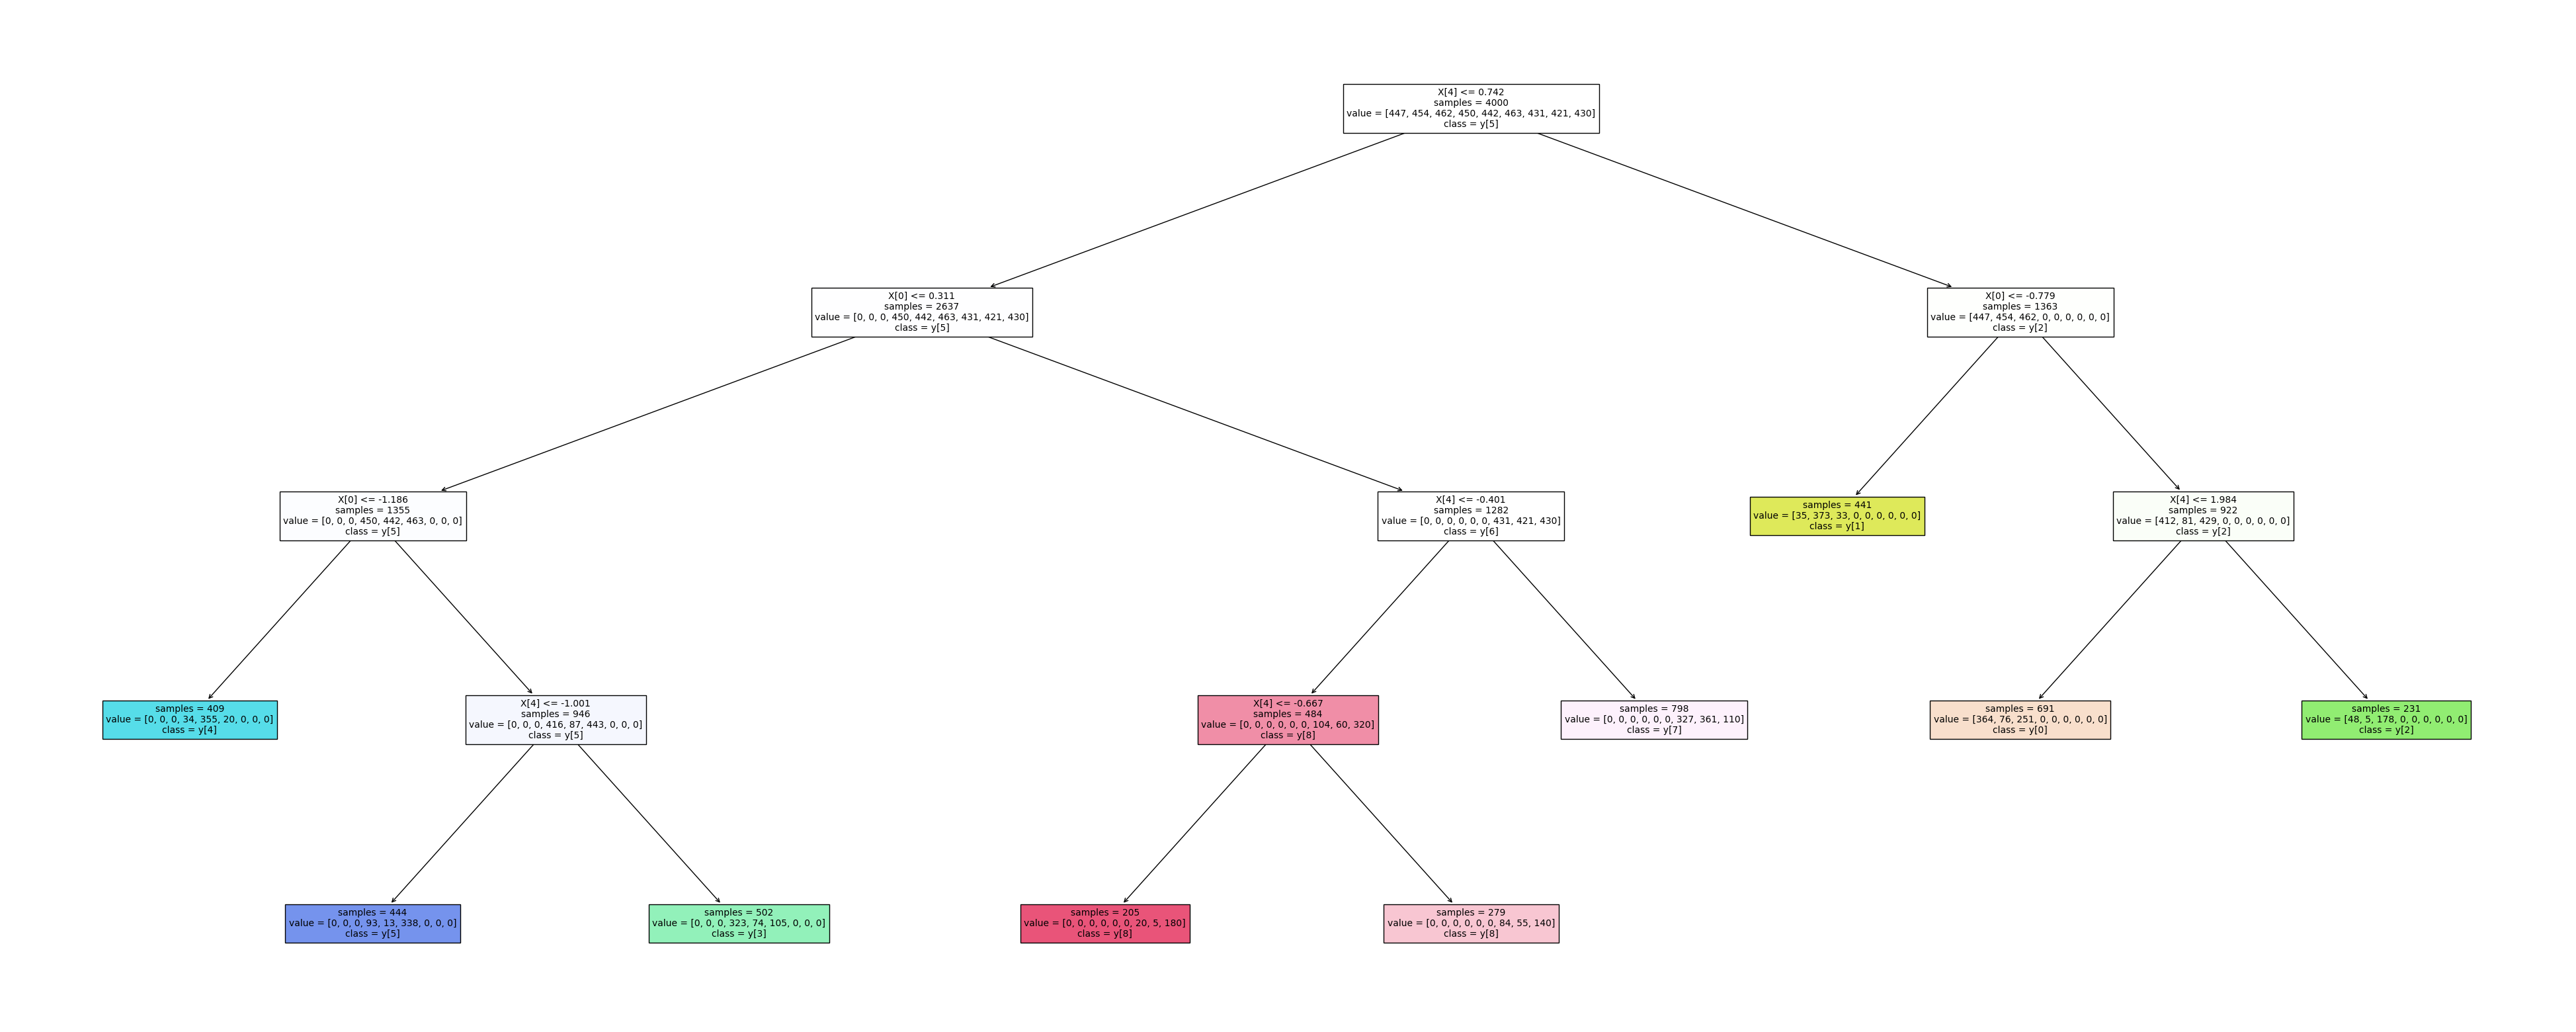

In [13]:
fig, ax = plt.subplots(figsize=(50, 20))
plot_tree(clf, ax=ax, class_names=True, impurity=0, max_depth=5, filled=True, fontsize=10)
fig.show()

In [61]:
X, y = d[29000:]
y, int2y = y2label(y)

with torch.no_grad():
    mu, log_var = model.encode(X)
    Z = model.reparameterize(mu, log_var)